In [1]:
from my_functions import*

In [2]:
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") #opening the Root file with Uproot 
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

In [3]:
#Prepare the data for the plots

#Choose the range of events to plot
nmin=0
nmax=100

#Select quality 0 Z->mumu
Zmumu_pt=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin:nmax]
Zmumu_eta=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin:nmax]
Zmumu_phi=quality_selector(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin:nmax]

#And select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi = get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)


#Select the ZeroBias data with energy cut
ZeroBias_eta=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin:nmax]
ZeroBias_phi=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin:nmax]
ZeroBias_pt=energy_cut(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin:nmax]

quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected
quality_selector: Only 21.265 % of the data has been selected


100%|██████████| 100/100 [00:00<00:00, 1214.11it/s]


energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut
energy_cut: Only 5.79% of the events have survived the cut with a lower cut of 14000 and no upper cut


muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


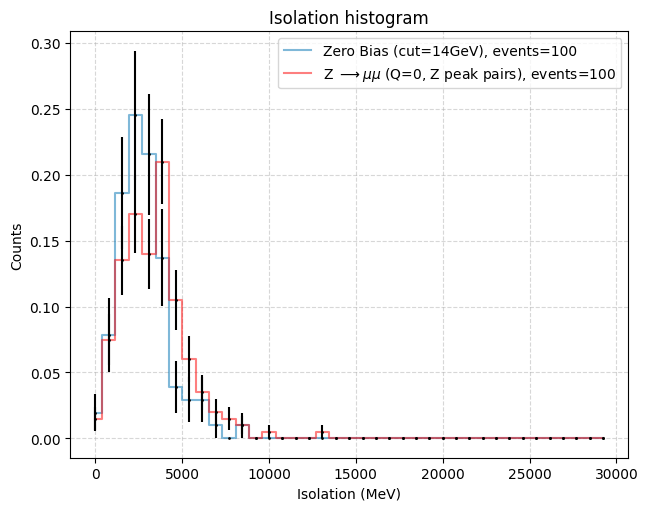

In [4]:
#Check how many events are not empty
non_empty_count1= ak.sum(ak.num(ZeroBias_eta[nmin:nmax]) > 0)
non_empty_count2 = ak.sum(ak.num(Zmumu_eta[nmin:nmax]) > 0)

#Compute the isolation and prepare it for plotting ZeroBias
res=muon_isolation_all_events(MuonTree_ZeroBias,ZeroBias_eta,ZeroBias_phi,0.0,0.3,[nmin,nmax],100)
data1=ak.flatten(res)

#Compute the isolation and prepare it for plotting Z mu mu
res=muon_isolation_all_events(MuonTree_Zmumu,Zmumu_eta,Zmumu_phi,0.0,0.3,[nmin,nmax],100)
data2=ak.flatten(res)

colors=["#0072B2", "#FD0000"]
labels=[fr"Zero Bias (cut=14GeV), events={non_empty_count1}",fr"Z $\longrightarrow \mu \mu$ (Q=0, Z peak pairs), events={non_empty_count2}"]

#Plot the data
coolplot([data1,data2],np.linspace(0,30000,40),colors,labels, "Isolation (MeV)","Counts","Isolation histogram")

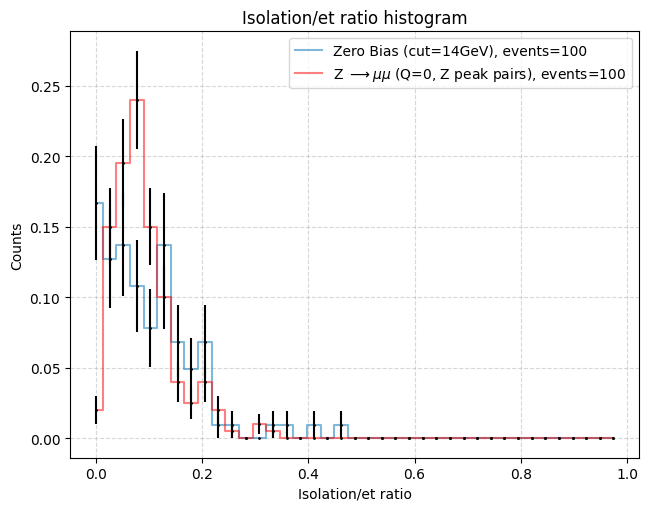

In [5]:
#Prepare the data
ratio1=data1/ak.flatten(ZeroBias_pt)
ratio2=data2/ak.flatten(Zmumu_pt)

#Plot the data
colors=["#0072B2", "#FD0000"]
labels=[fr"Zero Bias (cut=14GeV), events={non_empty_count1}",fr"Z $\longrightarrow \mu \mu$ (Q=0, Z peak pairs), events={non_empty_count2}"]

coolplot([ratio1,ratio2],np.linspace(0,1,40),colors,labels, "Isolation/et ratio","Counts","Isolation/et ratio histogram")

muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
muon_isolation_all_events: Computing muon isolation: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]
Computing ROC curve: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


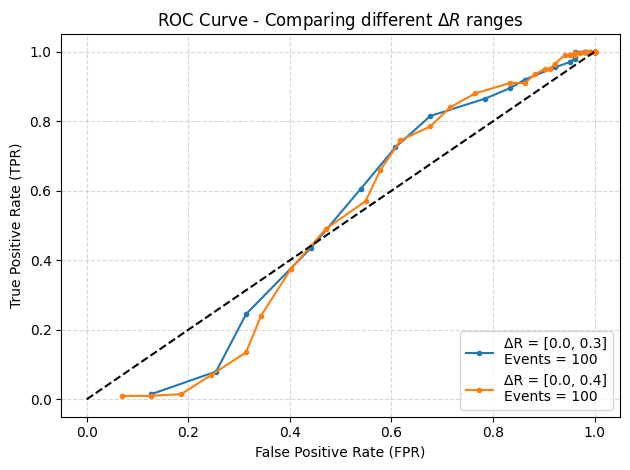

In [6]:
#Now let's do the ROC curve
#Number of bins is proportional to the square root of the number of events for scale 
bins=np.linspace(0,1,5*int(np.sqrt(nmax-nmin)))
dr_min=[0.0,0.0]
dr_max=[0.3,0.4]

#Prepare the data for the plots
ROC_curve=plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, [nmin,nmax],[nmin,nmax],bins,dr_min,dr_max)

In [7]:
def ROC_curve_distance(ROC_curve):
    """
    This function aims to optimise the delta R parameters so I get the 'best' ROC curve. A good estimator is to 
    minimise the distance between the curve and the top left corner. To do so, I can compute the distance for all
    points and try to minimise it by adding small variations to an initial guess of delta R.

    To begin with, this function computes the distance between the curve and the top left corner for all points,
    using the pythagorean theorem.

    Inputs:
    - ROC_curve: array of points of the ROC curve

    Returns:
    - Distances: array of distances between the curve and the top left corner
    """
    distances=[]
    for i in range(len(ROC_curve)):
        distances.append(np.sqrt((1-ROC_curve[i][0])**2+(1-ROC_curve[i][1])**2))
    return distances

In [8]:
ROC_curve 

[[<Array [0.127, 0.255, 0.314, 0.441, 0.539, ..., 1, 1, 1, 1] type='49 * float64'>,
  <Array [0.015, 0.08, 0.245, 0.435, 0.605, ..., 1, 1, 1, 1] type='49 * float64'>],
 [<Array [0.0686, 0.127, 0.186, 0.245, ..., 1, 1, 1, 1] type='49 * float64'>,
  <Array [0.01, 0.01, 0.015, 0.07, 0.135, ..., 1, 1, 1, 1, 1] type='49 * float64'>]]

In [9]:
len(ROC_curve)
ROC_curve_distance(ROC_curve)

[<Array [1.32, 1.18, 1.02, 0.795, 0.607, ..., 0, 0, 0, 0, 0] type='49 * float64'>,
 <Array [1.36, 1.32, 1.28, 1.2, 1.1, 1, ..., 0, 0, 0, 0, 0] type='49 * float64'>]

In [10]:
np.mean(ROC_curve_distance(ROC_curve[1]))

np.float64(1.3381572959680563)

In [11]:
def ROC_curve_optimiser(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, Zmumu_range, ZeroBias_range, bins):
    """
    This function aims to optimise the delta R parameters so I get the 'best' ROC curve. A good estimator is to 
    minimise the distance between the curve and the top left corner. To do so, I can compute the distance for all points
    and try to minimise it by adding small variations to an initial guess of delta R.
    """
    
    dr_min_guess=dr_min
    dr_max_guess=dr_max
    ROC_curve=plot_ROC_curve(MuonTree_Zmumu, MuonTree_ZeroBias, Zmumu_pt, Zmumu_eta, Zmumu_phi, ZeroBias_pt, ZeroBias_eta,
                ZeroBias_phi, [nmin,nmax],[nmin,nmax],bins,dr_min,dr_max)
    distance=ROC_curve_distance(ROC_curve)
    for i in range(len(ROC_curve)):
        guess[i]=ROC_curve[i][0]
    return guess
ROC_curve_optimiser(ROC_curve)


TypeError: ROC_curve_optimiser() missing 10 required positional arguments: 'MuonTree_ZeroBias', 'Zmumu_pt', 'Zmumu_eta', 'Zmumu_phi', 'ZeroBias_pt', 'ZeroBias_eta', 'ZeroBias_phi', 'Zmumu_range', 'ZeroBias_range', and 'bins'